In [25]:
from scipy.optimize import curve_fit
import numpy as np
import plotly.graph_objects as go
import pandas as pd



from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_fitness_metrics(y_true, y_pred, num_params):
    # Residuals
    residuals = y_true - y_pred
    
    # Metrics
    r_squared = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # AIC and BIC (assuming Gaussian errors)
    n = len(y_true)
    residual_sum_of_squares = np.sum(residuals**2)
    log_likelihood = -n / 2 * (np.log(2 * np.pi * residual_sum_of_squares / n) + 1)
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood
    
    # Return all metrics
    return {
        "R-squared": r_squared,
        "RMSE": rmse,
        "MAE": mae,
        "AIC": aic,
        "BIC": bic
    }


# Read the CSV file
datatxt_all = pd.read_csv('primes_data120000.txt')
datatxt_all=datatxt_all[datatxt_all["Number"]% 6 == 0].iloc[80000:90000]

# Count occurrences of each number in the relevant columns
number_counts_primes_plus_one = datatxt_all['Primes +1'].value_counts().sort_index()
number_counts_primes_minus_one = datatxt_all['Primes -1'].value_counts().sort_index()
number_counts_primes_twins = datatxt_all['Twins'].value_counts().sort_index()

# Logarithmic fit function
def log_fit(x, a, b):
    return a * np.log(x) + b

# Reciprocal logarithmic fit function with constraints
def reciprocal_log_fit(x, c, d):
    return c / np.log(x) + d

# Function to fit and plot data with continuity at the threshold
"""def fit_and_plot_with_constraints(data, threshold, title):
    x_data = data.index.to_numpy()
    y_data = data.values

    # Split data into before and after threshold
    x_before = x_data[x_data <= threshold]
    y_before = y_data[:len(x_before)]
    x_after = x_data[x_data > threshold]
    y_after = y_data[len(x_before):]

    # Ensure non-empty before and after threshold
    if len(x_before) < 2 or len(x_after) < 2:
        print(f"Insufficient data for fitting {title}")
        return

    # Fit log model to the data before the threshold
    try:
        popt_before, _ = curve_fit(log_fit, x_before, y_before, maxfev=5000)
    except RuntimeError:
        print(f"Log fit failed for {title}")
        return

    # Calculate the value of the log fit at the threshold
    threshold_value = log_fit(threshold, *popt_before)

    # Fit reciprocal log model to the data after the threshold
    try:
        # Adjust the initial guess for c_initial and d_initial to ensure valid bounds
        c_initial = np.max(y_after) * np.log(np.min(x_after))  # Initial guess for c
        d_initial = np.max([1, 1 - c_initial / np.log(np.max(x_after))])  # Ensure d >= 1

        bounds_after = ([0, 1], [np.inf, np.inf])  # Ensure d >= 1

        def adjusted_reciprocal_log_fit(x, c, d):
            return c / np.log(x) + d + (threshold_value - reciprocal_log_fit(threshold, c, d))

        popt_after, _ = curve_fit(
            adjusted_reciprocal_log_fit, x_after, y_after,
            p0=[c_initial, d_initial],
            bounds=bounds_after,
            maxfev=5000
        )
    except RuntimeError:
        print(f"Reciprocal log fit failed for {title}")
        return

    # Generate fitted values
    y_fit_before = log_fit(x_before, *popt_before)
    y_fit_after = adjusted_reciprocal_log_fit(x_after, *popt_after)

    # Plot the results
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='markers', name='Original Data'))
    fig.add_trace(go.Scatter(x=x_before, y=y_fit_before, mode='lines', name='Log Fit (Before Threshold)'))
    fig.add_trace(go.Scatter(x=x_after, y=y_fit_after, mode='lines', name='Reciprocal Log Fit (After Threshold)'))
    fig.add_vline(x=threshold, line=dict(color="green", dash="dash"), name="Threshold")
    fig.update_layout(
        title=title,
        xaxis_title="Number",
        yaxis_title="Count",
        legend_title="Legend"
    )
    fig.show()

    # Print the fitted parameters for reference
    print(f"Fitted Parameters for {title}:")
    print(f"Log Fit (Before Threshold): a = {popt_before[0]}, b = {popt_before[1]}")
    print(f"Reciprocal Log Fit (After Threshold): c = {popt_after[0]}, d = {popt_after[1]}")
"""
def fit_and_plot_with_constraints(data, threshold, title):
    x_data = data.index.to_numpy()
    y_data = data.values

    # Split data into before and after threshold
    x_before = x_data[x_data <= threshold]
    y_before = y_data[:len(x_before)]
    x_after = x_data[x_data > threshold]
    y_after = y_data[len(x_before):]

    # Ensure non-empty before and after threshold
    if len(x_before) < 2 or len(x_after) < 2:
        print(f"Insufficient data for fitting {title}")
        return

    # Fit log model to the data before the threshold
    try:
        popt_before, _ = curve_fit(log_fit, x_before, y_before, maxfev=5000)
    except RuntimeError:
        print(f"Log fit failed for {title}")
        return

    # Calculate the value of the log fit at the threshold
    threshold_value = log_fit(threshold, *popt_before)

    # Fit reciprocal log model to the data after the threshold
    try:
        c_initial = np.max(y_after) * np.log(np.min(x_after))  # Initial guess for c
        d_initial = np.max([1, 1 - c_initial / np.log(np.max(x_after))])  # Ensure d >= 1
        bounds_after = ([0, 1], [np.inf, np.inf])

        def adjusted_reciprocal_log_fit(x, c, d):
            return c / np.log(x) + d + (threshold_value - reciprocal_log_fit(threshold, c, d))

        popt_after, _ = curve_fit(
            adjusted_reciprocal_log_fit, x_after, y_after,
            p0=[c_initial, d_initial],
            bounds=bounds_after,
            maxfev=5000
        )
    except RuntimeError:
        print(f"Reciprocal log fit failed for {title}")
        return

    # Generate fitted values
    y_fit_before = log_fit(x_before, *popt_before)
    y_fit_after = adjusted_reciprocal_log_fit(x_after, *popt_after)

    # Plot the results
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='markers', name='Original Data'))
    fig.add_trace(go.Scatter(x=x_before, y=y_fit_before, mode='lines', name='Log Fit (Before Threshold)'))
    fig.add_trace(go.Scatter(x=x_after, y=y_fit_after, mode='lines', name='Reciprocal Log Fit (After Threshold)'))
    fig.add_vline(x=threshold, line=dict(color="green", dash="dash"), name="Threshold")
    fig.update_layout(
        title=title,
        xaxis_title="Number",
        yaxis_title="Count",
        legend_title="Legend"
    )
    fig.show()

    # Calculate fitness metrics
    fitness_before = calculate_fitness_metrics(y_before, y_fit_before, len(popt_before))
    fitness_after = calculate_fitness_metrics(y_after, y_fit_after, len(popt_after))

    # Display metrics
    print(f"Fitted Parameters for {title}:")
    print(f"Log Fit (Before Threshold): a = {popt_before[0]}, b = {popt_before[1]}")
    print(f"Reciprocal Log Fit (After Threshold): c = {popt_after[0]}, d = {popt_after[1]}")
    print("\nFitness Metrics:")
    print(f"Before Threshold: {fitness_before}")
    print(f"After Threshold: {fitness_after}")

# Example application
fit_and_plot_with_constraints(number_counts_primes_plus_one, threshold=4956, title="Log and Reciprocal Log Fit for Primes +1")
fit_and_plot_with_constraints(number_counts_primes_minus_one, threshold=4956, title="Log and Reciprocal Log Fit for Primes -1")
fit_and_plot_with_constraints(number_counts_primes_twins, threshold=304, title="Log and Reciprocal Log Fit for Twins")


Insufficient data for fitting Log and Reciprocal Log Fit for Primes +1
Insufficient data for fitting Log and Reciprocal Log Fit for Primes -1
Insufficient data for fitting Log and Reciprocal Log Fit for Twins


545


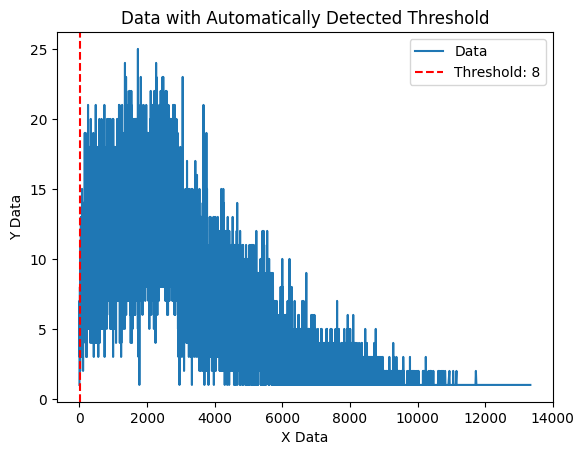

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def calculate_threshold(x_data, y_data):
    """
    Automatically calculate the threshold by detecting a significant change
    in the slope of the data (inflection point).
    """
    # Compute the first derivative (slope)
    first_derivative = np.gradient(y_data, x_data)

    # Compute the second derivative (curvature)
    second_derivative = np.gradient(first_derivative, x_data)

    # Find where the second derivative changes sign (indicating an inflection point)
    inflection_points = np.where(np.diff(np.sign(second_derivative)))[0]

    # Choose the first inflection point as the threshold (or adjust based on context)
    print(inflection_points[300])
    if len(inflection_points) > 5:
        threshold_index = inflection_points[3]
        threshold = x_data[threshold_index]
    else:
        threshold = x_data[len(x_data)//2]  # Default to the middle of the data if no inflection found

    return threshold

def plot_data_with_threshold(x_data, y_data, threshold):
    """
    Plot the data and the automatically detected threshold.
    """
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold: {threshold}")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title("Data with Automatically Detected Threshold")
    plt.show()
data=number_counts_primes_plus_one
# Example data (replace with your actual data)
x_data = data.index.to_numpy()
y_data = data.values

# Calculate threshold
threshold = calculate_threshold(x_data, y_data)

# Plot the data with the detected threshold
plot_data_with_threshold(x_data, y_data, threshold)


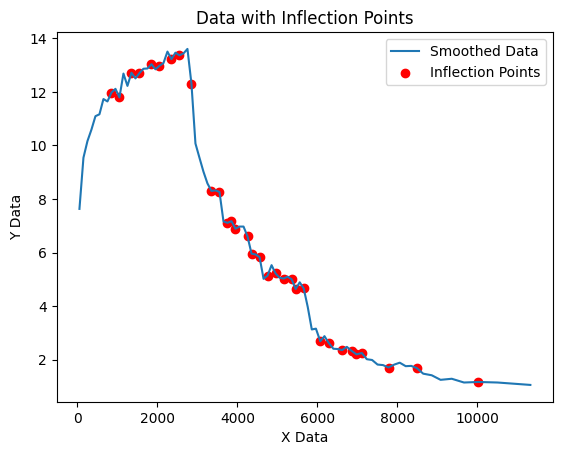

[ 8 10 13 15 18 20 23 25 28 33 35 37 38 39 42 43 45 47 49 51 53 54 56 60
 62 65 67 68 69 74 79 85]


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_data(x_data, y_data, group_size=100):
    """
    Group data into intervals and calculate the mean of each group.
    """
    # Calculate number of groups
    num_groups = len(x_data) // group_size
    
    # Create arrays to store the means
    smoothed_x = []
    smoothed_y = []
    
    for i in range(num_groups):
        # Select the current group
        group_x = x_data[i * group_size: (i + 1) * group_size]
        group_y = y_data[i * group_size: (i + 1) * group_size]
        
        # Calculate the mean of the current group
        smoothed_x.append(np.mean(group_x))
        smoothed_y.append(np.mean(group_y))
    
    return np.array(smoothed_x), np.array(smoothed_y)

def calculate_inflection_points(x_data, y_data):
    """
    Calculate the inflection points (where the second derivative changes sign).
    """
    # Compute the first and second derivatives
    first_derivative = np.gradient(y_data, x_data)
    second_derivative = np.gradient(first_derivative, x_data)
    
    # Find where the second derivative changes sign
    inflection_points = np.where(np.diff(np.sign(second_derivative)))[0]
    
    return inflection_points

def plot_data_with_inflection_points(x_data, y_data, inflection_points):
    """
    Plot the data and mark the inflection points.
    """
    plt.plot(x_data, y_data, label="Smoothed Data")
    plt.scatter(x_data[inflection_points], y_data[inflection_points], color='red', label="Inflection Points")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title("Data with Inflection Points")
    plt.show()

# Example data (replace with your actual data)


# Step 1: Smooth the data by grouping into intervals of 50 points
smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size=100)

# Step 2: Calculate the inflection points
inflection_points = calculate_inflection_points(smoothed_x, smoothed_y)

# Step 3: Plot the data and mark the inflection points
plot_data_with_inflection_points(smoothed_x, smoothed_y, inflection_points)
print(inflection_points)


max 13335


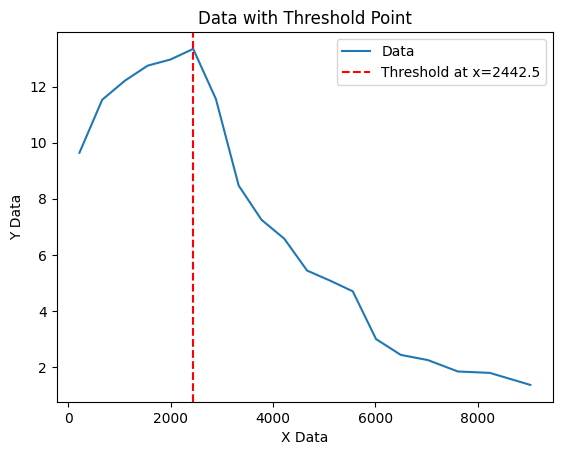

Calculated Threshold: 2442.5
max2 13296


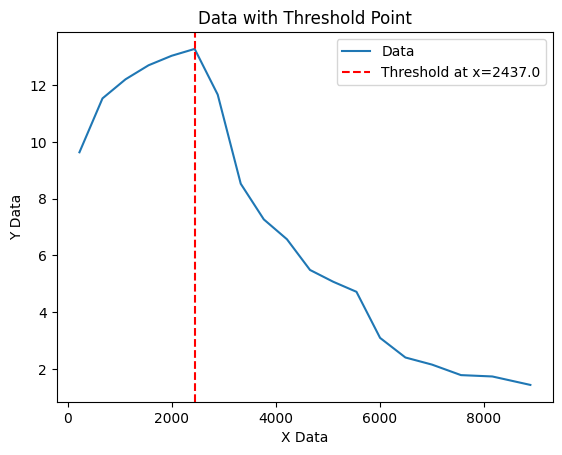

Calculated Threshold: 2437.0
max 3056
151.0


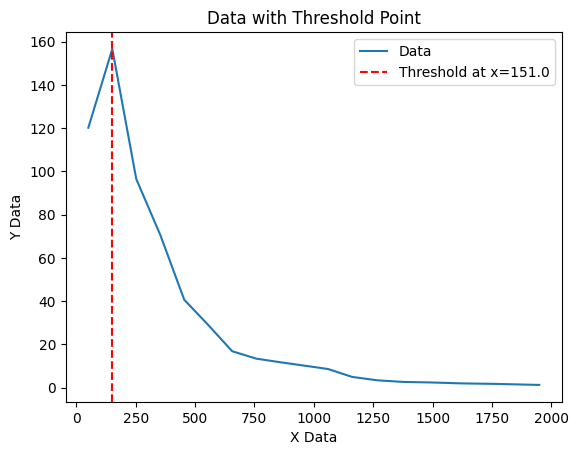

Calculated Threshold: 151.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def smooth_data(x_data, y_data, group_size):
    """
    Group data into intervals and calculate the mean of each group.
    """
    # Calculate number of groups
    num_groups = len(x_data) // group_size
    
    # Create arrays to store the means
    smoothed_x = []
    smoothed_y = []
    
    for i in range(num_groups):
        # Select the current group
        group_x = x_data[i * group_size: (i + 1) * group_size]
        group_y = y_data[i * group_size: (i + 1) * group_size]
        
        # Calculate the mean of the current group
        smoothed_x.append(np.mean(group_x))
        smoothed_y.append(np.mean(group_y))
    
    return np.array(smoothed_x), np.array(smoothed_y)

def find_threshold(x_data, y_data):
    """
    Find the threshold where the first derivative becomes negative (decreasing).
    """
    # Calculate the first derivative (difference between consecutive y-values)
    first_derivative = np.diff(y_data)
    
    # Find the index where the first derivative becomes negative
    threshold_index = np.argmax(first_derivative < 0)  # First index where the derivative is negative
    
    # Return the x-value corresponding to the threshold
    threshold = x_data[threshold_index]
    return threshold

def plot_data_with_threshold(x_data, y_data, threshold):
    """
    Plot the data and mark the threshold point.
    """
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold at x={threshold}")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title("Data with Threshold Point")
    plt.show()

# Example data (replace with your actual data)
datatxt_all = pd.read_csv('primes_data60000.txt')
datatxt_all=datatxt_all
divid=30
# Count occurrences of each number in the relevant columns
number_counts_primes_plus_one = datatxt_all['Primes +1'].value_counts().sort_index()
number_counts_primes_minus_one = datatxt_all['Primes -1'].value_counts().sort_index()
number_counts_primes_twins = datatxt_all['Twins'].value_counts().sort_index()
data=number_counts_primes_plus_one
x_data = data.index.to_numpy()
y_data = data.values
print("max",x_data[-1])
group_size=x_data[-1]//divid
# Step 1: Smooth the data by grouping into intervals of 50 points
smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size=group_size)

# Step 2: Find the threshold where the data starts to decrease
threshold = find_threshold(smoothed_x, smoothed_y)

# Step 3: Plot the data and mark the threshold
plot_data_with_threshold(smoothed_x, smoothed_y, threshold)

print(f"Calculated Threshold: {threshold}")
data=number_counts_primes_minus_one
x_data = data.index.to_numpy()
y_data = data.values
print("max2",x_data[-1])
group_size=x_data[-1]//divid
# Step 1: Smooth the data by grouping into intervals of 50 points
smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size=group_size)

# Step 2: Find the threshold where the data starts to decrease
threshold = find_threshold(smoothed_x, smoothed_y)

# Step 3: Plot the data and mark the threshold
plot_data_with_threshold(smoothed_x, smoothed_y, threshold)

print(f"Calculated Threshold: {threshold}")
data=number_counts_primes_twins
x_data = data.index.to_numpy()
y_data = data.values
print("max",x_data[-1])
group_size=x_data[-1]//divid
# Step 1: Smooth the data by grouping into intervals of 50 points
smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size=group_size)

# Step 2: Find the threshold where the data starts to decrease
threshold = find_threshold(smoothed_x, smoothed_y)
print(threshold)
# Step 3: Plot the data and mark the threshold
plot_data_with_threshold(smoothed_x, smoothed_y, np.floor(threshold))

print(f"Calculated Threshold: {np.floor(threshold)}")


In [48]:
import pandas as pd
import plotly.graph_objects as go

def plot_twin_counts(data, step_range, step_start, mod=None):
    """
    Generate and display scatter plots for twin counts.

    Parameters:
    - data (DataFrame): The input data for plotting.
    - step_range (tuple): The range of steps for the title.
    - step_start (int): Start index for the range.
    - mod (int, optional): Modulus value for filtering. Default is None (no filtering).
    """
    if mod is not None:
        # Filter data based on the modulus
        data = data[data['Number'] % 6 == mod]

    # Count occurrences of twin numbers
    twin_counts = data['Twins'].value_counts().sort_index()

    # Create the scatter plot
    fig = go.Figure(data=[
        go.Scatter(
            x=twin_counts.index,
            y=twin_counts.values,
            mode="markers",
            line=dict(color="red")
        )
    ])

    # Customize plot layout
    title_mod = f"; 6 mod {mod}" if mod is not None else ""
    fig.update_layout(
        title=f'Occurrences of Each Number of Twins (Range: {step_range[0]}-{step_range[1]}{title_mod})',
        xaxis_title='Number',
        yaxis_title='Count',
        template='plotly_dark'  # Optional: Dark theme for better aesthetics
    )

    # Display the plot
    fig.show()

# Read the CSV file once
file_path = 'primes_data120000.txt'
data_all = pd.read_csv(file_path)

# Process data in chunks
for step_start in range(10000, 130000, 10000):
    # Extract a subset of the data for the current step range
    step_end = step_start + 10000
    data_chunk = data_all.iloc[step_start - 10000:step_start]

    # Plot overall twin counts for the current range
    plot_twin_counts(data_chunk, step_range=(step_start - 10000, step_start), step_start=step_start)

    # Plot twin counts for each modulus from 0 to 5
    for mod in range(6):
        plot_twin_counts(data_chunk, step_range=(step_start - 10000, step_start), step_start=step_start, mod=mod)
